In [25]:
import numpy as np
from functools import reduce
import functions as fn
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from matplotlib.text import Text
from circuit_obj import Circuit
from itertools import product

from matplotlib import cm
from matplotlib.colors import LogNorm

from scipy.special import comb

import warnings

# 1) Globally ignore any warning whose text matches “too many iterations”
warnings.filterwarnings("ignore", message=".*too many iterations.*")

# from joblib import Parallel, delayed
colors = ["#394F87", "#A0B2E8", "#F0BCC1", "#7F0E0E"]
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
norm = plt.Normalize(vmin=0, vmax=np.pi)
smJ = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)

In [26]:
N = 20

# Circuit parameters
T = 1000
circuit_realizations = 2
symmetry = ['U1', 'SU2', 'Z2', 'ZK'][0]
geometry = ['random', 'brickwork'][1]
alphaT = 1 # Parameter to slice the circuit thinner

# Mask parameters
sites_to_keep = range((N-8), N)
qkeep = np.array(sites_to_keep)
qthrow = np.arange(N)[np.isin(np.arange(N), qkeep, invert=True)]
Ns = len(sites_to_keep)

Ne = N - Ns
projectors_s, U_U1_s = fn.build_projectors(Ns) 
projectors_e, U_U1_e = fn.build_projectors(Ne)
sectors_se = np.array([int(comb(N, int(N/2+m))) for m in np.arange(-N/2, N/2+1)])
sectors_s = np.array([int(comb(Ns, int(Ns/2+m))) for m in np.arange(-Ns/2, Ns/2+1)])
sectors_e = np.array([int(comb(Ne, int(Ne/2+m))) for m in np.arange(-Ne/2, Ne/2+1)])

masks_dict = fn.load_mask_memory(N, (2 if symmetry!='ZK' else K))

alphas = np.array([1]) # np.r_[np.linspace(0.1, 2, 10)]
qthrow = np.arange(N)[np.isin(np.arange(N), sites_to_keep, invert=True)]
alphas, sites_to_keep

(array([1]), range(12, 20))

In [27]:
def initial_state_test(target_sector):
    '''
    Create the 
    l state as (R_y(theta) |J_max>_Ns) tensor (|J_max>_Ne)
    '''
    assert target_sector <= Ns, "target_sector must be less than/eq the number of qubits in the system"
    
    # system:
    state_s = np.zeros(2**(len(qkeep)), dtype=np.complex128)
    cum_sectors_s = np.cumsum(sectors_s)
    
    if target_sector == int(target_sector):
        tgt = int(target_sector)
        element = cum_sectors_s[tgt-1] if tgt > 0 else 0
        element += sectors_s[tgt]//2
        state_s[element] = 1
        state_s[-element-1] = 1
    else:
        tgt = int(np.ceil(target_sector))
        element = cum_sectors_s[tgt-1] if tgt > 0 else 0
        element += sectors_s[tgt]//2
        state_s[element] = 1
        tgt = int(np.floor(target_sector))
        element = cum_sectors_s[tgt-1] if tgt > 0 else 0
        element += sectors_s[tgt]//2
        state_s[-element-1] = 1
    
    state_s /= np.linalg.norm(state_s)
    state_s = U_U1_s @ state_s
        
    #environment:
    state_e = np.zeros(2**(len(qthrow)), dtype=np.complex128)
    
    if not Ne % 2: # even
        size_zero_sector = sectors_e[Ne//2]
        start = (2**Ne - size_zero_sector)//2
        end = start + size_zero_sector
        state_e[start:end] = 1
    else:
        size_zero_sector = sectors_e[Ne//2]
        start = (2**Ne - 2*size_zero_sector)//2
        end = start + size_zero_sector
        state_e[start:end] = 1
        
    state_e = U_U1_e @ state_e
    
    state_e /= np.linalg.norm(state_e)

    return np.kron(state_e, state_s)

SYS:  ['0: 1.00', '1: 0.87', '2: 0.61', '3: 0.36', '4: 0.17', '5: 0.07', '6: 0.02', '7: 0.01', '8: 0.00']
SYS:  ['0: 1.00', '1: 0.93', '2: 0.74', '3: 0.50', '4: 0.29', '5: 0.14', '6: 0.05', '7: 0.02', '8: 0.00']
SYS:  ['0: 1.00', '1: 0.94', '2: 0.77', '3: 0.55', '4: 0.34', '5: 0.18', '6: 0.07', '7: 0.02', '8: 0.00']


[(0.9424777960769379, 1.5139535190379647),
 (1.2566370614359172, 1.7060443373693635),
 (1.5707963267948966, 1.7635033290792461)]

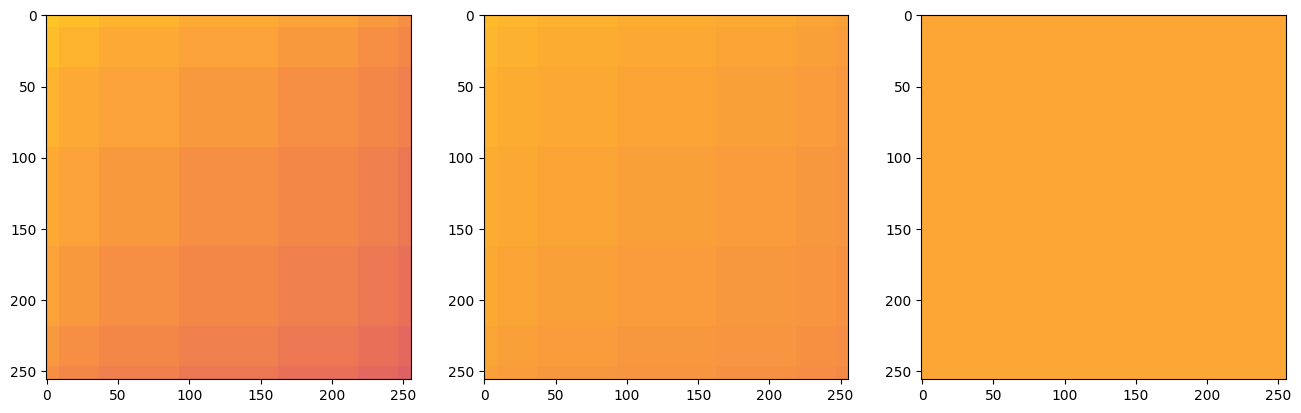

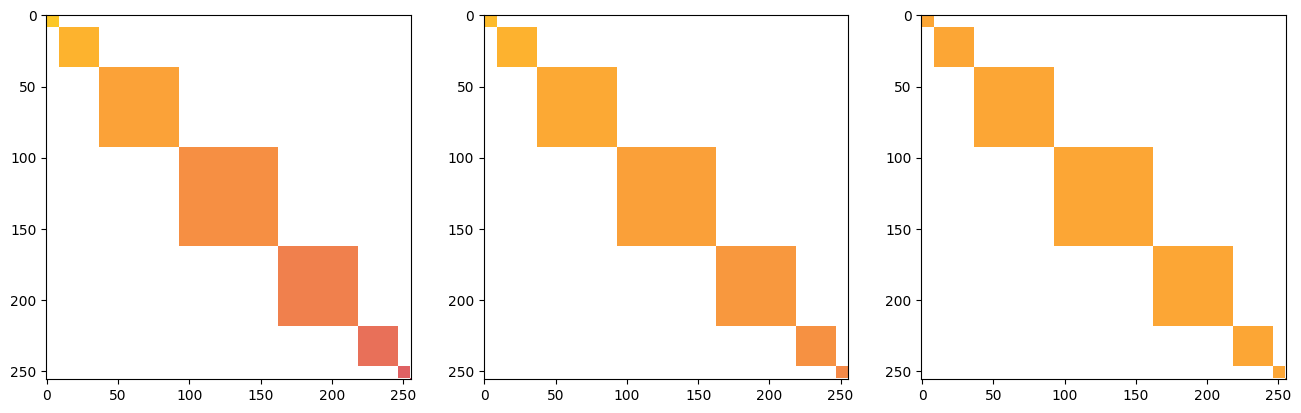

In [28]:
thetas = np.array([.3, .4, .5])*np.pi # theta


fig2, axs = plt.subplots(1, len(thetas), figsize=(16, 8))
fig3, ax1s = plt.subplots(1, len(thetas), figsize=(16, 8))
    
renyis = []
for idx, theta in enumerate(thetas):
    # state = initial_state_test(theta)
    state = fn.initial_state(N, sites_to_keep, theta, 'homogenous')
    
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s_U1 = U_U1_s.conj().T @ (rho_s) @ U_U1_s
    
    rho_s_tw = fn.manual_U1_tw(rho_s, projectors_s)
    rho_s_tw_U1 = U_U1_s.conj().T @ (rho_s_tw) @ U_U1_s
    
    cmap = cm.plasma.copy()
    cmap.set_bad(color='white')  # or 'none' for full transparency
    
    d1 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[idx].imshow(d1, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none') 
    
    d1 = np.ma.masked_less(np.abs(rho_s_tw_U1), 1e-12)
    im = ax1s[idx].imshow(d1, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none') 
    
    rho_modes = fn.asymmetry_modes(rho_s_U1, sectors_s)
    print('SYS: ', [f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}' for omega_idx, rho_omega in enumerate(rho_modes)])
    
    renyis.append((fn.renyi_divergence_sym(rho_s, symmetry, 1).real))
[*zip(thetas, renyis)]


In [29]:
if Ne < 12:
    
    fig2, axs = plt.subplots(1, 2, figsize=(16, 8))

    state = initial_state_test(theta)

    rho_e = fn.ptrace(state, qthrow)

    rho_e_tw = fn.manual_U1_tw(rho_e, projectors_e)

    cmap = cm.plasma.copy()
    cmap.set_bad(color='white')  # or 'none' for full transparency

    d1 = np.ma.masked_less(np.abs(U_U1_e.conj().T @ (rho_e) @ U_U1_e), 1e-12)
    im = axs[0].imshow(d1, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none') 

    d1 = np.ma.masked_less(np.abs(U_U1_e.conj().T @ (rho_e - rho_e_tw) @ U_U1_e), 1e-12)
    im = axs[1].imshow(d1, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none') 
        
    rho_e_U1 = U_U1_e.conj().T @ (rho_e) @ U_U1_e
    rho_modes = fn.asymmetry_modes(rho_e_U1, sectors_e)
    print('ENV: ', [f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}' for omega_idx, rho_omega in enumerate(rho_modes)])

    print((fn.renyi_divergence_sym(rho_e, symmetry, 1).real))


In [30]:
from scipy.special import comb
# given an initial state see how the modes are already populated 

# fig, axs = plt.subplots(len(thetas), N+1, figsize=(22, 16))
# fig, axs = plt.subplots(3, 3, figsize=(22, 16))
renyis = []
for theta_idx, theta in enumerate(thetas[:]):
    print(f'theta: {theta}')

    rho = fn.initial_state(N, sites_to_keep, theta, 'homogenous') # initial_state_test(theta)

    rho_s = fn.ptrace(rho, sites_to_keep)
    rho_e = fn.ptrace(rho, qthrow)

    # rho = U_U1_se.conj().T @ state @ U_U1_se
    # rho_modes = fn.asymmetry_modes(rho, sectors_se)
    # print([f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}' for omega_idx, rho_omega in enumerate(rho_modes)])
    
    rho_s = U_U1_s.conj().T @ rho_s @ U_U1_s
    rho_modes = fn.asymmetry_modes(rho_s, sectors_s)
    print('SYS: ', [f'{omega_idx}: {fn.compute_norm(rho_omega):.3f}' for omega_idx, rho_omega in enumerate(rho_modes)])

    # rho_e = U_U1_e.conj().T @ rho_e @ U_U1_e
    # rho_modes = fn.asymmetry_modes(rho_e, sectors_e)
    # print('ENV:', end=' ')
    # for omega_idx, rho_omega in enumerate(rho_modes):
    #     fn.compute_norm(rho_omega)
    #     print(f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}', end=' ')

        # d2 = np.ma.masked_less(np.abs(rho_omega), 1e-12)
        # im = axs[theta_idx, omega_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    # d2 = np.ma.masked_less(np.abs(rho), 1e-12)
    # axs[1, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
# fig.tight_layout()

theta: 0.9424777960769379
SYS:  ['0: 1.000', '1: 0.869', '2: 0.614', '3: 0.357', '4: 0.172', '5: 0.068', '6: 0.021', '7: 0.005', '8: 0.001']
theta: 1.2566370614359172
SYS:  ['0: 1.000', '1: 0.925', '2: 0.737', '3: 0.503', '4: 0.292', '5: 0.141', '6: 0.054', '7: 0.016', '8: 0.003']
theta: 1.5707963267948966
SYS:  ['0: 1.000', '1: 0.938', '2: 0.771', '3: 0.553', '4: 0.340', '5: 0.175', '6: 0.073', '7: 0.022', '8: 0.004']


In [31]:
import importlib
import circuit_obj, functions
importlib.reload(circuit_obj)
importlib.reload(functions)
Circuit = circuit_obj.Circuit
fn = functions

256


In [32]:
circuits = []
circuit_realizations_max = 100
if symmetry == 'U1':
    try:
        h_list_all = np.load(f'data/U1_rnd_parameters.npy')
        print('Loaded U1 parameters')
    except FileNotFoundError:
        h_list_all = np.random.uniform(-np.pi, np.pi, 5*N*circuit_realizations_max).reshape(circuit_realizations_max, N, 5) /alphaT
        np.save(f'data/U1_rnd_parameters.npy', h_list_all)
        print('Generated U1 parameters')
elif symmetry == 'SU2':
    try:
        h_list_all = np.load(f'data/SU2_rnd_parameters.npy')
    except FileNotFoundError:
        h_list_all = np.random.uniform(-np.pi, np.pi, 1*N*circuit_realizations_max).reshape(circuit_realizations_max, N, 1) /alphaT
        np.save(f'data/SU2_rnd_parameters.npy', h_list_all)
        
snapshots_t = np.array([t for t in [0, 10, 50, 100, 300, 500, 1000] if t <= T])


for circuit_realization in range(circuit_realizations):
    if symmetry == 'U1':
        h_list = h_list_all[circuit_realization]
        gates = [fn.gen_u1([*h]) for h in h_list]
    elif symmetry == 'SU2':
        h_list = h_list_all[circuit_realization]
        gates = [fn.gen_su2(*h) for h in h_list]

    order = fn.gen_gates_order(N, geometry=geometry)    
    circuit = Circuit(N=N, T=T, gates=gates, order=order, symmetry=symmetry)
    circuit.projectors = projectors_s
    circuit.U_U1_s = U_U1_s
    circuit.sectors_s = sectors_s
    circuit.Ns = Ns
    circuit.snapshots_t = snapshots_t
    circuits.append(circuit)
len(circuits)

Loaded U1 parameters


2

In [33]:
def compute_circuit(theta, circuit_real):
    circuit = circuits[circuit_real]
    rho = fn.initial_state(N, sites_to_keep, theta, 'homogenous') # initial_state_test(theta)
    return circuit.run(masks_dict, sites_to_keep, alphas, rho)

if globals().get('renyi') is None or globals(
    ).get('renyi').shape != (circuit_realizations, len(thetas), len(alphas), T + 1):
    renyi = np.zeros((circuit_realizations, len(thetas), len(alphas), T + 1), dtype=np.float64)
    
if globals().get('norms_s') is None or globals(
    ).get('norms_s').shape != (circuit_realizations, len(thetas), T + 1, Ns+1):
    norms_s = np.zeros((circuit_realizations, len(thetas), T + 1, Ns+1), dtype=np.float64)
    
if globals().get('evo') is None or globals(
    ).get('evo').shape != (circuit_realizations, len(thetas), T + 1, 2**N):
    evo = np.zeros((circuit_realizations, len(thetas), T + 1, 2**N), dtype=np.complex128)

for theta_i, circuit_real in tqdm(product(
        range(len(thetas)), #
        range(circuit_realizations), 
    ), total=len(thetas) * circuit_realizations):
    theta = thetas[theta_i]
    print(f'circuit_realization: {circuit_real}, theta: {theta/np.pi:.2f} pi')
    a0, a1, a2 = compute_circuit(theta, circuit_real)
    renyi[circuit_real, theta_i, :, :], norms_s[circuit_real, theta_i, :, :], evo[circuit_real, theta_i, :, :] = a0, a1, a2
    np.savez(f'data/{symmetry}_theta{theta/np.pi:.2f}_circuit_real{circuit_real}_T{T}.npz',
            renyi=a0, 
            norms_s=a1, 
            evo=a2,
            theta=theta,
            circuit_real=circuit_real,
            alphas=alphas,
            T=T,
            Ns=Ns,
            N=N,
        )
    

  0%|          | 0/6 [00:00<?, ?it/s]

circuit_realization: 0, theta: 0.30 pi


 17%|█▋        | 1/6 [05:49<29:09, 349.97s/it]

circuit_realization: 1, theta: 0.30 pi


 33%|███▎      | 2/6 [12:00<24:08, 362.19s/it]

circuit_realization: 0, theta: 0.40 pi


 50%|█████     | 3/6 [18:19<18:29, 369.71s/it]

circuit_realization: 1, theta: 0.40 pi


 67%|██████▋   | 4/6 [24:43<12:31, 375.60s/it]

circuit_realization: 0, theta: 0.50 pi


 83%|████████▎ | 5/6 [31:12<06:20, 380.23s/it]

circuit_realization: 1, theta: 0.50 pi


100%|██████████| 6/6 [37:44<00:00, 377.35s/it]


In [86]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for theta_idx, theta in enumerate(thetas):
    res_ = np.mean(renyi[:, theta_idx, 0, :], axis=0)
    # fn.print_matrix(res[:, theta_idx, 0, :])
    # print()
    ax.plot(res_, label=f'{theta:.2f}', ls='-', marker='.')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [ ]:
%matplotlib osx 
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

color_ = ax._get_lines.get_next_color()
for mode in range(Ns+1):
    for theta_idx, theta in enumerate(thetas):
        ls_ = ['-','-.',':'][theta_idx%4]
        temp_norm = norms_s[0, theta_idx, :, mode].astype(np.float64) #np.mean(norms_s[:, theta_idx, :, mode].astype(np.float64), axis=0)
        
        ti, tf = 10, T
        t = np.arange(ti, tf)
        ln_t = np.log(t)
        ln_y = np.log(temp_norm[ti:tf])
        
        # do a simple linear regression: ln_y = C - b*ln_t
        A = np.vstack([ln_t, np.ones_like(ln_t)]).T
        slope1, intercept1 = np.linalg.lstsq(A, ln_y, rcond=None)[0]
        ax.plot(t, np.exp(intercept1 + slope1 * ln_t), color=color_, linewidth=4, alpha=.45)
        ax.plot(temp_norm, linestyle=ls_, color=color_, label=rf'$\omega={mode}, \theta={theta/np.pi:.2f}$, b={slope1:.10f}')
        # ax.plot(temp_norm, '.', color=color_,)
        color_ = ax.lines[-1].get_color()
    color_ = ax._get_lines.get_next_color()
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

: 

In [36]:
%matplotlib osx
# fig, axs = plt.subplots(len(snapshots_t[-2:]), len(thetas), figsize=(12, 8))
renyis = []
modes_e = np.zeros((len(thetas), len(snapshots_t), Ne+1))
avg_s = np.zeros((len(thetas), len(snapshots_t), Ns+1))
avg_e = np.zeros((len(thetas), len(snapshots_t), Ne+1))
for theta_idx, theta in enumerate(thetas):
    for t in range(T):
        
        rho_s = np.zeros((2**Ns, 2**Ns), dtype=np.complex128)
        rho_e = np.zeros((2**Ne, 2**Ne), dtype=np.complex128)
        for circuit_real in tqdm(range(circuit_realizations)):
            state = evo[circuit_real,theta_idx,t,:]
            rho_s += fn.ptrace(state, sites_to_keep)
            rho_e += fn.ptrace(state, qthrow)
        rho_s /= circuit_realizations
        rho_e /= circuit_realizations
        rho_s_U1 = U_U1_s.conj().T @ rho_s @ U_U1_s 
        rho_e_U1 = U_U1_e.conj().T @ rho_e @ U_U1_e
        # d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
        # im = axs[time_idx, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
        rho_s_modes = fn.asymmetry_modes(rho_s_U1, sectors_s)
        print(theta_idx, t, )
        print('SYS: ', [f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}' for omega_idx, rho_omega in enumerate(rho_s_modes)])
        avg_s[theta_idx, t, :] = [np.sum(np.abs(rho_s_mode)) for rho_s_mode in rho_s_modes]
        rho_e_modes = fn.asymmetry_modes(rho_e_U1, sectors_e)
        modeee = [fn.compute_norm(rho_omega) for omega_idx, rho_omega in enumerate(rho_e_modes)]
        modes_e[theta_idx, t, :] = modeee
        print('ENV: ', [f'{omega_idx}: {fn.compute_norm(rho_omega):.2f}' for omega_idx, rho_omega in enumerate(modeee)])
        avg_e[theta_idx, t, :] = [np.sum(np.abs(rho_e_mode)) for rho_e_mode in rho_e_modes]
        
    
fig.tight_layout()

100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


0 0
SYS:  ['0: 1.00', '1: 0.87', '2: 0.61', '3: 0.36', '4: 0.17', '5: 0.07', '6: 0.02', '7: 0.01', '8: 0.00']


ValueError: Expected a 2D array, got shape ()

In [77]:
cum_sectors_s = np.cumsum(sectors_s)
def get_sector_avg(pts):
    new_pts = np.zeros_like(pts)
    start = 0
    avgs = np.zeros_like(cum_sectors_s, np.float64)
    for sector_idx, end in enumerate(cum_sectors_s):
        temp_avg = np.mean(pts[start:end])
        new_pts[start:end] = temp_avg
        avgs[sector_idx] = temp_avg
        start = end
    return new_pts, avgs

In [82]:
%matplotlib osx
fig, axs = plt.subplots(3, len(thetas), figsize=(12, 10))
fig, axs1 = plt.subplots(2, 1, figsize=(8, 10))
for yline in cum_sectors_s:
    axs1[0].axvline(yline, color='k', linestyle='--', alpha=.5)
renyis = []
for theta_idx, theta in enumerate(thetas):
    t = 0
    # rho_s = np.zeros((2**Ns, 2**Ns), dtype=np.complex128)
    # for circuit_real in tqdm(range(circuit_realizations)):
    state = evo[circuit_real,theta_idx,t,:]
    rho_s = fn.ptrace(state, sites_to_keep)
    # rho_s /= circuit_realizations
    rho_s_U1 = U_U1_s.conj().T @ rho_s @ U_U1_s 
    # for omega_idx, rho_omega in enumerate([rho_modes[0]]):
    #     d2 = np.ma.masked_less(np.abs(rho_omega), 1e-12)
    #     im = axs[0, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[0, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    diag = np.diag(d2)
    diag_avg, avgs = get_sector_avg(diag)
    print(avgs)
    axs1[0].plot(diag_avg, alpha=.5, linewidth=2)
    axs1[0].plot(diag, label=f'{theta:.2f}, t={t}', ls='-')
    ax1s[1].plot(avgs, label=f'{theta:.2f}, t={t}', ls='-')
    
    
    t = 20
    state = evo[circuit_real,theta_idx,t,:]
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s_U1 = U_U1_s.conj().T @ rho_s @ U_U1_s     
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[1, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    color_ = axs1[0].lines[-1].get_color()
    diag = np.diag(d2)
    diag_avg, avgs = get_sector_avg(diag)
    print(avgs)
    axs1[0].plot(diag_avg, alpha=.5, linewidth=2, color=color_)
    axs1[0].plot(diag, label=f'{theta:.2f}, t={t}', ls='--', color=color_)
    ax1s[1].plot(avgs, label=f'{theta:.2f}, t={t}', ls='--', color=color_)
    
    
    t = T-1
    state = evo[circuit_real,theta_idx,t,:]
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s_U1 = U_U1_s.conj().T @ rho_s @ U_U1_s     
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[2, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    diag = np.diag(d2)
    diag_avg, avgs = get_sector_avg(diag)
    print(avgs)
    axs1[0].plot(diag_avg, alpha=.5, linewidth=2, color=color_)
    axs1[0].plot(diag, label=f'{theta:.2f}, t={t}', ls=':', color=color_)
    ax1s[1].plot(avgs, label=f'{theta:.2f}, t={t}', ls=':', color=color_)
    ax1s[0].plot(cum_sectors_s, avgs, label=f'{theta:.2f}, t={t}', ls=':', color=color_, linewidth=2, marker='o')
axs1[0].legend()
axs1[0].set_yscale('log')  
axs1[1].set_yscale('log')  
fig.tight_layout()

[1.57795330e-01 4.09662213e-02 1.06354940e-02 2.76114637e-03
 7.16838284e-04 1.86102820e-04 4.83153038e-05 1.25434348e-05
 3.25647867e-06]
[2.99064805e-01 5.70203124e-02 6.60884447e-03 9.30571884e-04
 1.01015798e-04 9.12402569e-06 1.04088353e-06 2.25538065e-07
 2.51465628e-08]
[3.12005086e-01 6.20233119e-02 5.81287701e-03 4.89769351e-04
 2.21093289e-05 1.26268142e-06 8.55942528e-08 2.31477522e-09
 5.25784447e-11]
[0.03367614 0.01777642 0.00938353 0.00495323 0.00261463 0.00138017
 0.00072854 0.00038457 0.000203  ]
[1.27926891e-01 4.68052537e-02 1.06534947e-02 2.73543374e-03
 5.67631032e-04 1.03190990e-04 2.05083270e-05 7.53390202e-06
 1.56757872e-06]
[1.76828492e-01 5.62341194e-02 9.90615800e-03 1.51322795e-03
 1.47228254e-04 1.48869132e-05 1.60944502e-06 8.13792223e-08
 3.27761895e-09]
[0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625]
[4.67553567e-02 2.78720213e-02 1.13168789e-02 4.69906319e-03
 1.64959034e-03 5.26177495e-04 1.6357693

In [ ]:
def size_omega_subspace(Ns):
    """
    Calculate the size of the omega subspace for a given number of qubits Ns.
    The size of the omega subspace is defined as the number of ways to choose
    m1 and m2 such that m1 - m2 = omega, where m1 and m2 are the number of
    qubits in the first and second half of the system, respectively.
    """
    # Initialize a dictionary to store the size of the omega subspace
    size_omega = {}

    for m1 in np.arange(-Ns/2, Ns/2+1):
        for m2 in np.arange(-Ns/2, Ns/2+1):
            omega_key = int(m1 - m2)
            # print(m1, m2, end='; ')
            if omega_key not in size_omega:
                size_omega[omega_key] = 0
            size_omega[omega_key] += comb(Ns, int(Ns/2+m1)) * comb(Ns, int(Ns/2+m2))

    # sort the dictionary by key
    sorted_size_omega = dict(sorted(size_omega.items()))
    size_omega = {}
    # print the sorted dictionary
    for key, value in sorted_size_omega.items():
        if key>0:
            # print(f"{key}: {value*2}")
            size_omega[key] = value*2
            
    # convert the dictionary to a numpy array
    size_omega_array = np.array(list(size_omega.values())[::-1], dtype=np.float64)
    # print the numpy array
    return size_omega #size_omega_array

size_omega_subspace(N)[7]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

state = np.mean(evo[:, 4, T-1, :], axis=0)
rho_s = fn.ptrace(state, sites_to_keep)
rho_s_tw = fn.manual_U1_tw(rho_s, projectors_s)
rho_s_U1 = U_U1_s.conj().T @ (rho_s - rho_s_tw) @ U_U1_s
rho_s_U1 = U_U1_s.conj().T @ (rho_s) @ U_U1_s
rho_s_modes = fn.asymmetry_modes(rho_s_U1, sectors_s)

rho_eq = rho_s_U1.copy()
d1 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)

rho_eq[rho_eq != 0] = np.mean(d1)


cmap = cm.plasma.copy()
cmap.set_bad(color='white')  # or 'none' for full transparency

ax.imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none') 

from scipy.sparse import csr_matrix
# print(csr_matrix(d1))
np.mean(d1), np.std(d1),  np.max(d1), np.min(d1)

In [ ]:
(0.000715776840252967, 7.666467083416871e-20)
(0.00020219214750874813, 8.464466801715275e-05)
(9.286443172843784e-05, 5.5277308879935246e-05)
(8.18469776915174e-05, 4.591417324268909e-05)
(7.19991515530784e-05, 4.192462579240732e-05)
(5.525441391170834e-05, 3.1446906009458656e-05)
(, 2.4.8989316690781734e-05784783389054931e-05)

